In [1]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

# Define directories
pluvial_dir = "Pluvial_def_1in100"
fluvial_dir = "Fluvial_def_1in100"
output_dir = "Combined_Fluvial_Pluvial"  # Directory to save the combined TIFF files

# Define file names
file_names = ["n29w098.tif", "n29w099.tif", "n30w098.tif", "n30w099.tif"]

# Generate file paths
tif_files_pluvial = [os.path.join(pluvial_dir, file) for file in file_names]
tif_files_fluvial = [os.path.join(fluvial_dir, file) for file in file_names]



In [5]:
# Apply filtering to pluvial and fluvial data
filtered_pluvial_dir = "Filtered_Pluvial"
filtered_fluvial_dir = "Filtered_Fluvial"
filter_and_save_tif(tif_files_pluvial, filtered_pluvial_dir)
filter_and_save_tif(tif_files_fluvial, filtered_fluvial_dir)


In [10]:

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to combine filtered pluvial and fluvial data for each lat-lon
def combine_and_save_tif(pluvial_files, fluvial_files, output_dir):
    for pluvial_file, fluvial_file in zip(pluvial_files, fluvial_files):
        with rasterio.open(pluvial_file) as pluvial_ds, rasterio.open(fluvial_file) as fluvial_ds:
            # Read the data from both pluvial and fluvial files
            pluvial_data = pluvial_ds.read(1)
            fluvial_data = fluvial_ds.read(1)
            
            # Get the metadata from the pluvial file (assuming both have the same metadata)
            meta = pluvial_ds.meta
            
            # Check if no-data values are set, if not, assign a default value
            pluvial_nodata = pluvial_ds.nodata if pluvial_ds.nodata is not None else -9999
            fluvial_nodata = fluvial_ds.nodata if fluvial_ds.nodata is not None else -9999
            
            # Combine the data: keep the maximum value (pluvial or fluvial) at each lat-lon point
            combined_data = np.maximum(pluvial_data, fluvial_data)
            
            # Set no-data values where either image has no-data
            combined_data[pluvial_data == pluvial_nodata] = pluvial_nodata
            combined_data[fluvial_data == fluvial_nodata] = fluvial_nodata
            
            # Generate output file path
            output_path = os.path.join(output_dir, os.path.basename(pluvial_file))
            
            # Write the combined data to a new TIFF file
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(combined_data, 1)
            print(f"Saved combined file: {output_path}")

# Generate file paths for the filtered pluvial and fluvial files
pluvial_files = [os.path.join(filtered_pluvial_dir, file) for file in file_names]
fluvial_files = [os.path.join(filtered_fluvial_dir, file) for file in file_names]

# Combine and save the pluvial and fluvial files
combine_and_save_tif(pluvial_files, fluvial_files, output_dir)

print("All combined TIFF files have been saved.")


Saved combined file: Combined_Fluvial_Pluvial/n29w098.tif
Saved combined file: Combined_Fluvial_Pluvial/n29w099.tif
Saved combined file: Combined_Fluvial_Pluvial/n30w098.tif
Saved combined file: Combined_Fluvial_Pluvial/n30w099.tif
All combined TIFF files have been saved.


<ipython-input-11-02751be45526>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar


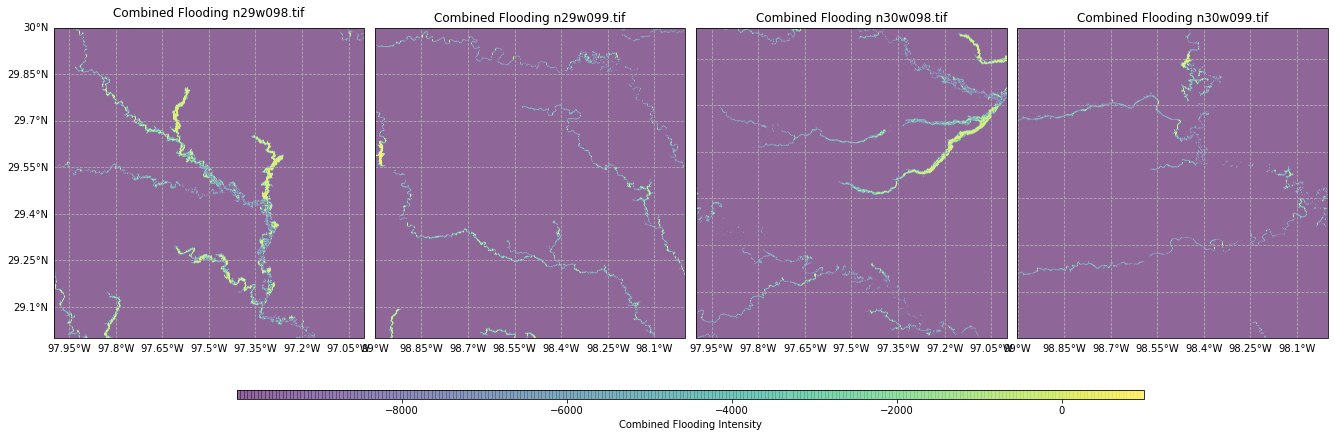

In [11]:
# Define directory containing the combined TIFF files
combined_dir = "Combined_Fluvial_Pluvial"  # Directory where combined files are saved

# Define the file names for each lat-lon grid
file_names = ["n29w098.tif", "n29w099.tif", "n30w098.tif", "n30w099.tif"]

# Function to plot combined TIFF files on a map
def plot_combined_tif_on_map(tif_path, ax, title, show_grid=False, show_longitude=True):
    with rasterio.open(tif_path) as dataset:
        img = dataset.read(1)  # Read first band
        bounds = dataset.bounds
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
        
        # Masking no-data values
        img = np.ma.masked_equal(img, dataset.nodata)
        
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES, linestyle='--', edgecolor='gray')
        
        gl = ax.gridlines(draw_labels=show_grid or show_longitude, linestyle="--")
        gl.right_labels = False
        gl.top_labels = False
        if not show_grid:
            gl.left_labels = False
            gl.bottom_labels = show_longitude
        
        img_plot = ax.imshow(img, extent=extent, transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.6)
        ax.set_title(title)
        return img_plot

# Create figure and axes for plotting
fig, axes = plt.subplots(1, 4, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()

# Plot combined images
img_plots_combined = []
for i, file_name in enumerate(file_names):
    tif_path = os.path.join(combined_dir, file_name)
    title = f"Combined Flooding {file_name}"
    show_grid = (i == 0)  # Show grid only for the first image
    img_plot = plot_combined_tif_on_map(tif_path, axes[i], title, show_grid, show_longitude=True)
    img_plots_combined.append(img_plot)

# Create colorbar for combined images
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Combined colorbar position
cbar = fig.colorbar(img_plots_combined[-1], cax=cbar_ax, orientation='horizontal')
cbar.set_label("Combined Flooding Intensity")

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar
plt.show()